### Obliczanie temperatury elemetów stalowych:

Naduś guzik **Run** na górze strony aby wykonać blok kodu.

Kod jest otwarty i można w nim wprawadzać dowolne zmiany.

HE 200 A
shadow effect!
Selected profile: HE 200 A
Its Am/V ratio is: 211.0
Its Am/V (box) ratio is: 145.0
k_sh = : 0.618
Data taken from Arcelor Mittal

Time: 0.0s | Gas temp: 20.0 degC | Element temp: 20.0 degC
Time: 5.0s | Gas temp: 96.5 degC | Element temp: 20.5 degC
Time: 10.0s | Gas temp: 147.0 degC | Element temp: 21.3 degC
.
.
.
.
.
Time: 1785.0s | Gas temp: 840.5 degC | Element temp: 811.2 degC
Time: 1790.0s | Gas temp: 841.0 degC | Element temp: 812.0 degC
Time: 1795.0s | Gas temp: 841.4 degC | Element temp: 812.9 degC
Time: 1800.0s | Gas temp: 841.8 degC | Element temp: 813.7 degC
0 20.0
5 20.46
10 21.26
15 22.34
20 23.66
25 25.2
30 26.93
35 28.84
40 30.9
45 33.12
50 35.47
55 37.96
60 40.56
65 43.28
70 46.1
75 49.02
80 52.03
85 55.14
90 58.33
95 61.59
100 64.93
105 68.35
110 71.83
115 75.37
120 78.98
125 82.64
130 86.35
135 90.12
140 93.94
145 97.81
150 101.72
155 105.67
160 109.67
165 113.7
170 117.77
175 121.87
180 126.01
185 130.18
190 134.38
195 138.61
200 142.86
205 147

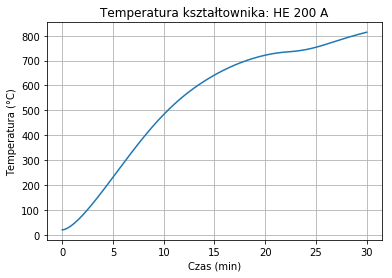

In [6]:
# -*- coding: utf-8 -*-
%matplotlib inline
"""
Obliczanie temperatury elmentow stalowych zgodnie z PN EN 1993-1-2
UWAGA: emisyjnosc stali ustawic w module heat.py
       "em_steel = 0.8" lub "em_steel = 0.7"

Projekt w fazie realizacji
Mozna dodawac nowe profile w "database_profiles.py": skladnia: 'NAZWA (np. HEB200)': [Am/V, Am/V(box)]
lub recznie wpisac wartosci w liniach AmV oraz AmVb
Nazwy profili w bazie zgodne z Arcelor Mittal
http://sections.arcelormittal.com/products-services/products-ranges.html
np. z serii IPE 180:
IPE AA 180, IPE A 180, IPE 180, IPE O 180
z serii HE 200:
HE 200 AA, HE 200 A, HE 200 B, HE 200 C, HE 200 M

Z uwagi na pewne niedociągnięcia serwisu, ktorego uzywam do trzymania skryptu skrypt w wersji on-line jest daleki od idealu.
- kiepska jakos wykresu (wiele nieobslugiwanych funkcji, chocby grid)
- brak wsparcia python3 w wersji darmowej
- dostepnosc tylko wybranych modulow
"""
# Ustawiane przez uzytkownika:
profile_type = 'dwuteownik'  # 'dwuteownik' lub 'rura'
profile_name = 'HE 200 A'  # wypelnic jesli dwuteownik / patrz opis wyzej. Symbole jak w database_profiles
grubosc_scianki_rury = 6.0  # wypelnic jesli rura
czas_analizy = 1800  # czas analizy w sekundach
# czy drukowac na koncu liste czas-temperatura:
drukuj = 'tak'  # 'tak lub cokolwiek innego'
ekspozycja = 'ISO-834'
# mozliwe ekspozycje: 'ISO-834', 'LP', 'ISO-834-1800-dacay-1800'

#####################################
# Koniec ustawien uzytkownika
# Ponizej nie trzeba niczego zmieniac
#####################################
import sys
sys.path.append('C:\\Users\\wojciech\\Documents\\Python Scripts\\heat_steel')
from math import log10
import numpy as np
import database_profiles as dp
import material_prop as mp
#import interpolate_mine as interp
import heat


    
if profile_type == 'dwuteownik':
    AmV = dp.data_miner(profile_name)[3]
    AmVb = dp.data_miner(profile_name)[5]
    print(profile_name)
    one_sided_list = ['HEB200-1', 'HEA200-1', 'HEA200-1-simplified',
                      'HE_300_simplified', 'HE_300_accurate',
                      'IPE_200_simplified', 'IPE_200_accurate']
    if profile_name in one_sided_list:
        k_sh = AmVb / AmV
        print('one side!')
    else:
        k_sh = 0.9 * AmVb / AmV
        print('shadow effect!')
    #
    print("Selected profile: %s" % profile_name)
    print("Its Am/V ratio is: %.1f" % AmV)
    print("Its Am/V (box) ratio is: %.1f" % AmVb)
    print("k_sh = : %.3f" % k_sh)
    print("Data taken from Arcelor Mittal\n")
elif profile_type == 'rura':
    AmV = 1.0 / (grubosc_scianki_rury / 1000.)
    k_sh = 1.0
    print("Selected profile: tube with t = %.1f\n" % grubosc_scianki_rury)


temp_steel = 20
dtime = 5

def print_output():
    print("Time: %.1fs |" % time,
          "Gas temp: %.1f degC |" % temp,
          "Element temp: %.1f degC" % temp_steel)

def gas_temp(ekspozycja, time):
    if ekspozycja == 'ISO-834':
        temp = 20 + 345 * log10(8 * (time / 60.0) + 1)
    elif ekspozycja == 'LP':
        a = [0.0, 238.9, 316.0, 396.7, 499.4, 598.3, 697.0, 795.7, 850.9, 894.9, 946.1, 1044.8, 1099.5, 1146.8, 1194.1, 1245.1, 1333.2, 1439.7, 1494.7, 1590.4, 1697.0, 1800.1, 1892.2, 1965.7, 2090.7]
        b = [20.0, 20.0, 27.9, 53.1, 103.2, 169.2, 253.3, 348.7, 348.9, 362.6, 403.5, 505.8, 571.7, 653.4, 748.7, 814.6, 851.1, 860.4, 881.0, 863.0, 867.8, 838.6, 818.4, 811.7, 821.1]
        print(time)        
        temp = interp.void_interpolate(time, a, b)
    elif ekspozycja == 'ISO-834-1800-dacay-1800':
        decay_start = 1800
        decay_end = decay_start + 1800
        max_temp = 20 + 345 * log10(8 * (decay_start / 60.0) + 1)
        if time <= 1800:
            temp = 20 + 345 * log10(8 * (time / 60.0) + 1)
        else:
            # temp = 20  # testing
            if time < decay_end:
                procent = (time - decay_start) / (decay_end - decay_start)
                temp = max_temp - procent * (max_temp - 20)
            else:
                temp = 20
    return temp

time_list = []
steelTemp_list = []
time_steelTemp_list = []

for time in range(0, czas_analizy + 1, dtime):
    temp = gas_temp(ekspozycja, time)
    h_net = heat.HF_conv(temp, temp_steel) + heat.HF_rad(temp, temp_steel)
    dtemp = k_sh * (AmV / (mp.steel_sh(temp_steel) * 7850)) * h_net * dtime
    temp_steel += dtemp
    if time <= 10:
        print_output()
    elif time > czas_analizy * 0.99 and time > czas_analizy - 100:
        print_output()
    elif time % 300 == 0:
        print(".")
    else: pass
    time_list.append(time)
    steelTemp_list.append(temp_steel)
    time_steelTemp_list.append([time, temp_steel])

if profile_type == 'dwuteownik':
    file_name = profile_name
elif profile_type == 'rura':
    file_name = 'rura' + str(grubosc_scianki_rury)
else:
    file_name = 'something_went_wrong'

#np.savetxt('LP_time_' + file_name + '.txt', time_list, fmt='%.1f')
#np.savetxt('LP_steelTemp_' + file_name + '.txt', steelTemp_list, fmt='%.1f')


if drukuj == 'tak':
  for item in time_steelTemp_list:
    print(round(item[0], 0), round(item[1], 2))



if profile_type == 'dwuteownik':
    print("\nTemperatura przekroju %s po %.1fs (%.1f minut): "
          "%.1f stopni Celsjusza"
          % (profile_name, czas_analizy, czas_analizy / 60, temp_steel))
elif profile_type == 'rura':
    print("\nTemperatura rury o grubosci %.1f mm po %.1fs (%.1f minut): "
          "%.1f stopni Celsjusza"
          % (grubosc_scianki_rury, czas_analizy, czas_analizy / 60, temp_steel))

# Convert time list from seconds to minutes:
time_list_minutes = time_list  # copy list
time_list_minutes[:] = [x /60 for x in time_list]  # convert sec -> min

import matplotlib.pyplot as plt
plt.title('Temperature-time chart')
plt.plot(time_list_minutes, steelTemp_list)
plt.title('Temperatura kształtownika: %s' % profile_name)
plt.xlabel('Czas (min)')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()



### Play with plot only:

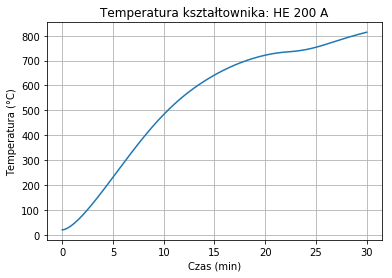

In [7]:
plt.title('Temperature-time chart')
plt.plot(time_list_minutes, steelTemp_list)
plt.title('Temperatura kształtownika: %s' % profile_name)
plt.xlabel('Czas (min)')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()